In [4]:
import tensorflow as tf

import os
import time

from matplotlib import pyplot as plt
from IPython import display

_URL = 'https://people.eecs.berkeley.edu/~tinghuiz/projects/pix2pix/datasets/facades.tar.gz'

path_to_zip = tf.keras.utils.get_file('facades.tar.gz',
                                      origin=_URL,
                                      extract=True, cache_dir='./data_loader', cache_subdir='data')

PATH = os.path.join(os.path.dirname(path_to_zip), 'facades/')
# saved in: /usr/local/google/home/ammarh/.keras/datasets/facades/

30171136/30168306 [==============================] - 1s 0us/step


<Figure size 1008x720 with 0 Axes>

(256, 256, 3)


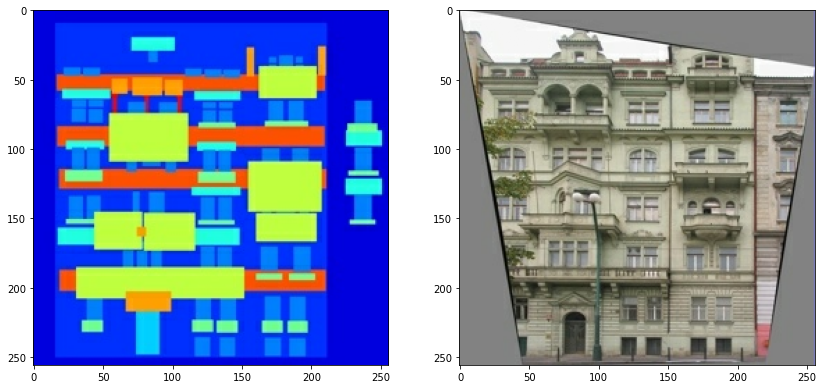

In [15]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)
  
  w = tf.shape(image)[1]
  w = w // 2
  real_image = image[:,:w,:]
  input_image = image[:,w:,:]
  real_image = tf.cast(real_image, tf.float32)
  input_image = tf.cast(input_image, tf.float32)
  
  return input_image, real_image

inp, re = load(PATH+'train/100.jpg')
plt.figure(figsize=(14,10));
plt.subplot(1,2,1);
plt.imshow(inp/255.0);
plt.subplot(1,2,2);
plt.imshow(re/255.0);
print(inp.shape)

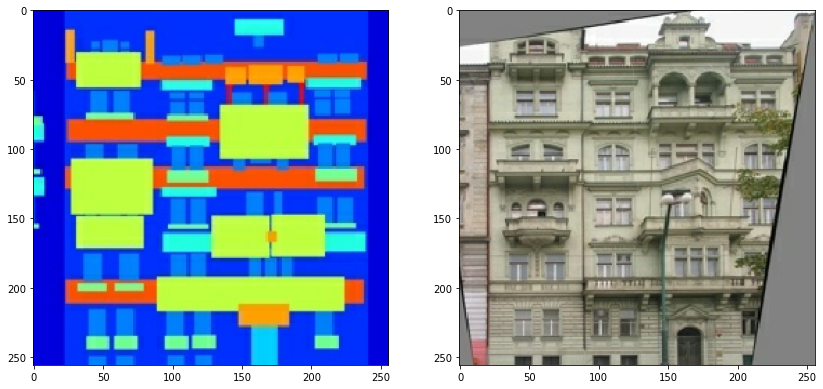

In [21]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

# normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

@tf.function()
def random_jitter(input_image, real_image):
  # resizing to 286 x 286 x 3
  input_image, real_image = resize(input_image, real_image, 286, 286)
  # randomly cropping to 256 x 256 x 3
  input_image, real_image = random_crop(input_image, real_image)
  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)
  return input_image, real_image

rj_inp, rj_re = random_jitter(inp, re)
plt.figure(figsize=(14,10));
plt.subplot(1,2,1);
plt.imshow(rj_inp/255.0);
plt.subplot(1,2,2);
plt.imshow(rj_re/255.0);

In [ ]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image